# Steinkauz

## Notebook: avo_for_density

See the [Steinkauz repository](https://github.com/bjornrommel/steinkauz/avo_for_density) for the code source.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Steinkauz

# load module
# (currently not used, but reserved for later)
%reload_ext steinkauz

# toggle input
###%inputtoggle

In [3]:
# Python, IPython

# import Python modules
import sys
import numpy as np

# import IPython modules
from IPython import display as dsp
import ipywidgets as ipw
from ipywidgets import interact, interactive, interactive_output

In [4]:
# Matplotlib

# set default parameters 
import matplotlib as mpl
mpl.rcParams['font.size'] = 11             # same font size as the LaTeX document
mpl.rcParams['text.usetex'] = True         # use latex throughout
mpl.rcParams['ps.usedistiller'] = 'xpdf'   # for production quality

# set API
from matplotlib import pyplot as plt       # use Matlab-like API

# set backend (ipympl integrates interactive features into Jupyter)
%matplotlib widget

In [5]:
# User-Defined Python 

# import notebook-specific functions
import avo_for_density as afd
import config as cfg

In [6]:
# define an input box for the S-to-P velocity ratio
vps_box = (
    ipw.BoundedFloatText(
        description="P-to-S velocity ratio", value=1./cfg.para['vsp'], min=0, step=0.1, max=sys.maxsize))

# <center> Elements of Seismic Data Processing: </center>

# <center> AVO Inversion for Density </center>

# <center> Björn E. Rommel </center>

## The Forward Problem

Commonly, the "forward problem" means simulating a physical process: we start with a model of reality, and then we calculate (observable) data based on the mathematical description of a physical law. Here, a plane wave impinging on an interface is reflected, partially transmitted, and the respective reflection / transmission coefficients are described by the Zoeppritz equation. 

The Zoeppritz equation depend on the seismic properties P-velocity, S-velocity and density on either side of the interface. For the sake of a better intuitive understand, and simplicity of computations, the Zoeppritz equation are commonly linearized in terms of small differences in seismic properties from their respective "background" (or average) medium. Then, a first-order linearized AVA depends on the normalized contrasts of seismic properties, the P-to-S velocity ratio of the background, and the incidence angles.

### Input of Seismic Properties

Nonetheless, traditionally, seismic properties, not their normalized contrasts, are input, as follows.

Tip: You can skip inputting these seismic properties, if you don't want to see a theoretical AVA curve, but to jump ahead to an AVA inversion.

In [7]:
# write top halfspace
display(dsp.Markdown("#### Top Halfspace:"))

# define input boxes for vp, vs, and rho in the top halfspace
vp1_box = ipw.BoundedFloatText(description="P-velocity", value=afd.VP1, min=0, step=10, max=sys.maxsize)
vs1_box = ipw.BoundedFloatText(description="S-velocity", value=afd.VS1, min=0, step=10, max=sys.maxsize)
rho1_box = ipw.BoundedFloatText(description="density", value=afd.RHO1, min=0, step=10, max=sys.maxsize)
    
# group input boxes into a horizontal row
top_box = ipw.GridBox(
    [vp1_box, vs1_box, rho1_box], 
    layout=ipw.Layout(grid_template_columns="repeat(3, 300px)"))
display(top_box)


# enforce stability criteria
def update_vp1_box(*args):
    global vp1_box
    if np.isfinite(vp1_box.value):
        if vp1_box.value <= 0.:
            print('top medium: vp < 0!')
            vp1_box.value = np.NAN
        if vp1_box.value <= np.sqrt(8. / 3.) * vs1_box.value:
            print('top medium: vp < sqrt(8 / 3) * vs!')
            vp1_box.value = np.NAN
vp1_box.observe(update_vp1_box, 'value')

def update_vs1_box(*args):
    global vs1_box
    if np.isfinite(vs1_box.value):
        if vs1_box.value <= 0.:
            print('top medium: vs < 0!')
            vs1_box.value = np.NAN
        if vs1_box.value >= np.sqrt(3. / 8.) * vp1_box.value:
            print('top medium: vs > sqrt(3 / 8) * vp!')
            vs1_box.value = np.NAN
vs1_box.observe(update_vs1_box, 'value')

def update_rho1_box(*args):
    global rho1_box
    if np.isfinite(rho1_box.value):
        if rho1_box.value <= 0.:
            print('top medium: rho < 0!')
            rho1_box.value = np.NAN
rho1_box.observe(update_rho1_box, 'value')


# write bottom halfspace
display(dsp.Markdown("#### Bottom Halfspace:"))

# define input boxes for vs, vs, and rho in the bottom halfspace
vp2_box = ipw.BoundedFloatText(description="P-velocity", value=afd.VP2, min=0, step=10, max=sys.maxsize)
vs2_box = ipw.BoundedFloatText(description="S-velocity", value=afd.VS2, min=0, step=10, max=sys.maxsize)
rho2_box = ipw.BoundedFloatText(description="density", value=afd.RHO2, min=0, step=10, max=sys.maxsize)

# group input boxes into a horizontal row
bot_box = ipw.GridBox(
    [vp2_box, vs2_box, rho2_box], 
    layout=ipw.Layout(grid_template_columns="repeat(3, 300px)"))
display(bot_box)


# enforce stability criteria
def update_vp2_box(*args):
    global vp2_box
    if np.isfinite(vp2_box.value):
        if vp2_box.value <= 0.:
            print('bottom medium: vp < 0!')
            vp2_box.value = np.NAN
        if vp2_box.value <= np.sqrt(8. / 3.) * vs2_box.value:
            print('bottom medium: vp < sqrt(8 / 3) * vs!')
            vp2_box.value = np.NAN
vp2_box.observe(update_vp2_box, 'value')

def update_vs2_box(*args):
    global vs2_box
    if np.isfinite(vs2_box.value):
        if vs2_box.value <= 0.:
            print('bottom medium: vs < 0!')
            vs2_box.value = np.NAN
        if vs2_box.value >= np.sqrt(3. / 8.) * vp2_box.value:
            print('bottom medium: vs > sqrt(3 / 8) * vp!')
            vs2_box.value = np.NAN
vs2_box.observe(update_vs2_box, 'value')

def update_rho2_box(*args):
    global rho2_box
    if np.isfinite(rho2_box.value):
        if rho2_box.value <= 0.:
            print('bottom medium: rho < 0!')
            rho2_box.value = np.NAN
rho2_box.observe(update_rho2_box, 'value')


# calculate prior model and S-to-P velocity ratio
def update_model(**kwargs):
    # check all properties are setafd.get_medium(vp=kwargs['vp1'])
    if not np.any([np.isnan(kwargs[prop]) for prop in ['vp1', 'vs1', 'rho1', 'vp2', 'vs2', 'rho2']]):
        # set up the top model
        afd.get_medium(halfspace='top', text='top', vp=kwargs['vp1'], vs=kwargs['vs1'], rho=kwargs['rho1'])
        # set up the bottom model
        afd.get_medium(halfspace='bot', text='bottom', vp=kwargs['vp2'], vs=kwargs['vs2'], rho=kwargs['rho2'])
        # set up the background model
        afd.get_back()
        # calculate the S-to-P velocity ratio
        afd.get_para()
        vps_box.value = 1. / afd.para['vsp']
        # compute the prior contrast
        afd.get_precon()
        # compute the prior model
        afd.get_prior()


# interact with input boxes and call for AVA calculation and curve preparation
out=interactive_output(
    update_model,
    {'vp1': vp1_box, 'vs1': vs1_box, 'rho1': rho1_box, 'vp2': vp2_box, 'vs2': vs2_box, 'rho2': rho2_box})
display(out)


# define an update button
def medbutton_action(*args):
    # wake up Jupyter
    pass

# interact with update button
medbutton =  ipw.Button(description = 'update', button_style = 'info', tooltip = 'update the prior model')
display(medbutton)
medbutton.on_click(medbutton_action)

#### Top Halfspace:

GridBox(children=(BoundedFloatText(value=2000.0, description='P-velocity', max=9.223372036854776e+18, step=10.…

#### Bottom Halfspace:

GridBox(children=(BoundedFloatText(value=2500.0, description='P-velocity', max=9.223372036854776e+18, step=10.…

Output()

Button(button_style='info', description='update', style=ButtonStyle(), tooltip='update the prior model')

### P-to-S Velocity Ratio

The P-to-S velocity ratio, or internally rather its inverse, is required for both the forward and inverse problem. If all seismic properties are input above, the P-to-S velocity ratio is automatically populated, but it can be overridden in the following; otherwise, the P-to-S velocity ratio must be input next.  

In [8]:
# interact with vps box
@interact(vps=vps_box)
def vsp_update(**kwargs):
    # update S-to-P velocity ratio
    afd.get_para(vps=kwargs['vps'])


# define an update button
def vspbutton_action(*args):
    # wake up Jupyter
    pass

# interact with update button
vspbutton =  ipw.Button(description = 'update', button_style = 'info', tooltip = 'update the S-to-P velocity ratio')
display(vspbutton)
vspbutton.on_click(vspbutton_action)

interactive(children=(BoundedFloatText(value=1.6666666666666667, description='P-to-S velocity ratio', max=9.22…

Button(button_style='info', description='update', style=ButtonStyle(), tooltip='update the S-to-P velocity rat…

### AVA Curve

Finally, the theoretical AVA curve can be calculated and displayed. 

In [9]:
# calculate and display an AVA curve based on a prior model
def ava_update(**kwargs):
    # check all properties are set
    # (note, an AVA curve depends strictly on the prior model and the S-to-P velocity ratio)
    if not (np.any(np.isnan(afd.prior['mod'])) or np.isnan(afd.para['vsp'])):
        # initialize figure 
        afd.init_plot(num=1, title='AVA Curve')   # figure number hard-wired 
        # calculate AVA points for the given prior model
        afd.comp_coeff(mode='COEFF')  
        # create a figure based on those AVA points
        afd.plot_all(mode='COEFF')      
        # exit figure
        afd.exit_plot(env=afd.PLOTENVIRONMENT)

# interact with input boxes and call the above AVA calculation and display
# (note, any change in any one of the following boxes already triggers a re-calcuation of the prior model or the S-to-P
# velocity ratio)
ava_box = interactive_output(ava_update, {'rho1': rho1_box, 'rho2': rho2_box, 'vps': vps_box})

# display AVA curve
display(ava_box)

Output()

## The Inverse Problem

The "inverse problem" is the opposite, that is inferring a model from available data. "Bayes's theory" of inversion aims to optimize that inference: based on already a-priori available information about the model, an estimate of the uncertainty of such prior information, and further based on an estimate of data quality, Bayes theory provides the optimal a-posteriori information possible.

In AVA inversion, here, the normalized contrasts make up the "model" in a Bayesian sense: as said, the properties to invert for. Hence, in a Bayesian context, the "prior model" comprises all information we have already derived from, e.g., a velocity analysis; and the "prior uncertainty" is the uncertainty with which we can perform a velocity analysis. 

The "parameters" in an AVA inversion are the P-to-S velocity ratio and the incidence angles. For now, let's assume, we know these parameters with zero uncertainty, although, admittedly, such accuracy will never be possible in practice.

Then, the "data" are the reflection / transmission coefficients. Here, the terms coefficients and "amplitude" are often mixed up: AVA-inversion requires the coefficients or normalized amplitudes, that is the amplitude ratio of a wave after and before reflection / transmission. True-amplitude processing seems elusive in practice, but that uncertainty is part of the "data uncertainty."

Tip: Re-run this cell to make the figure active. This is because Matplotlib keeps the last figure active, and so any interactive input will be plotted in that figure. The data -- amplitude over incidence angle -- can be input directly in the below figure. The order in which the data are input does not matter. You only need to click on the respective point in the display; the actual cursor position is shown at the bottom of the figure.

Tip: Due to a bug in Jupyter, I cannot make it accept double clicks for entering data points. And, so, single clicks are used for both the figure ornaments and data points. Hence, your best bet for now, don't change the figure layout.

Output()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
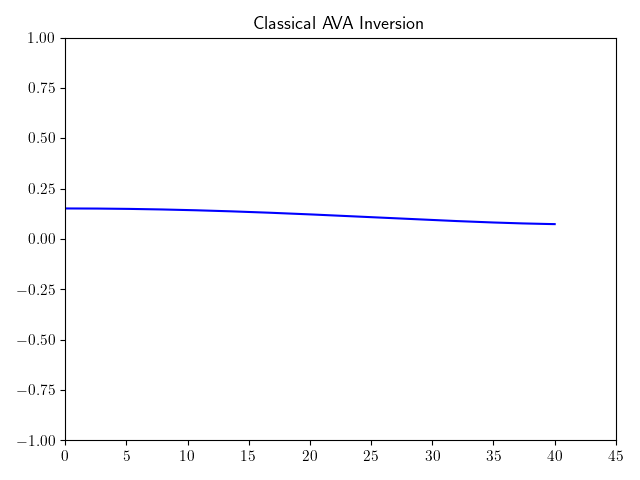

In [10]:
# input AVA data points and calculate best-fitting AVA curve
def data_update(**kwargs):
    # check all properties are set
    if not np.isnan(afd.para['vsp']):
        # initialize figure
        afd.init_plot(num=2, title='Classical AVA Inversion')
        # re-plot old data and AVA curve
        if afd.data['nos'] > 0:
            # re-invert data to posterior model 
            # (in case inversion method has changed w/o uncertainty or prior model)
            afd.invert_ava(mode='COEFF-DATA-AVA-')
            # re-calculate AVA curve from the posterior model
            afd.comp_post_ava()
            # re-plot old data and corresponding AVA curve
            afd.replot_data_ava(mode='COEFF-DATA-AVA-', num=2)
        # catch new data points, invert all data points, and plot an AVA curve based on the new posterior model
        afd.plot_all(mode='COEFF-DATA-AVA-', num=2)        

# interact with input boxes and call for AVA calculation and curve
out = interactive_output(data_update, {'vps': vps_box})

# display AVA curve
display(out)

### Prior Model Uncertainty

Let's take the prior model as above, and input only the prior uncertainty. Admittedly, estimating prior uncertainty is in itself another Bayesian problem. 

Tip: However, recall, a distribution of random numbers is almost entirely contained within 3 times its standard deviation (STD): so, estimate the maximum error of, e.g., our velocity analysis and devide that value by 3 to obtain the prior uncertainty expressed in terms of its standard deviation. Not perfect, but good enough for a first gestimate.

In [11]:
# write subtitle for the top halfspace
display(dsp.Markdown("#### Top Halfspace:"))

# write input boxes for seismic properties in the top halfspace
dvp1_box = ipw.BoundedFloatText(description="P-velocity +/-", value=afd.DVP1, min=0, step=1, max=sys.maxsize)
dvs1_box = ipw.BoundedFloatText(description="S-velocity +/-", value=afd.DVS1, min=0, step=1, max=sys.maxsize)
drho1_box = ipw.BoundedFloatText(description="density +/-", value=afd.DRHO1, min=0, step=1, max=sys.maxsize)

# line up input boxes for the top halfspace and display
dtop_box = ipw.GridBox(
    [dvp1_box, dvs1_box, drho1_box], 
    layout=ipw.Layout(grid_template_columns="repeat(3, 300px)"))
display(dtop_box)

# write subtitle for the bottom halfspace
display(dsp.Markdown("#### Bottom Halfspace:"))

# write input boxes for seismic properties in the bottom halfspace

dvp2_box = ipw.BoundedFloatText(description="P-velocity +/-", value=afd.DVP2, min=0, step=1, max=sys.maxsize)
dvs2_box = ipw.BoundedFloatText(description="S-velocity +/-", value=afd.DVS2, min=0, step=1, max=sys.maxsize)
drho2_box = ipw.BoundedFloatText(description="density +/-", value=afd.DRHO2, min=0, step=1, max=sys.maxsize)

# line up input boxes for the bottom halfspace and display
dbot_box = ipw.GridBox(
    [dvp2_box, dvs2_box, drho2_box], 
    layout=ipw.Layout(grid_template_columns="repeat(3, 300px)"))
display(dbot_box)

# update P-to-S velocity ratio, prior model and coefficients
def update_model(**kwargs):
    # check all properties are setafd.get_medium(vp=kwargs['vp1'])
    if not np.any([np.isnan(kwargs[prop]) for prop in ['dvp1', 'dvs1', 'drho1', 'dvp2', 'dvs2', 'drho2']]):
        # set up the top model
        afd.get_medium(halfspace='top', text='top', dvp=kwargs['dvp1'], dvs=kwargs['dvs1'], drho=kwargs['drho1'])
        # set up the bottom model
        afd.get_medium(halfspace='bot', text='bottom', dvp=kwargs['dvp2'], dvs=kwargs['dvs2'], drho=kwargs['drho2'])
        # set up the background model
        afd.get_back()
        # calculate parameters as, here, the S-to-P velocity ratio
        afd.get_para()
        # compute prior contrast
        afd.get_precon()
        # compute the prior
        afd.get_prior()
        
    
# interact with all input boxes
out = interactive_output(
    update_model, 
    {'dvp1': dvp1_box, 'dvs1': dvs1_box, 'drho1': drho1_box, 'dvp2': dvp2_box, 'dvs2': dvs2_box, 'drho2': drho2_box})
display(out)

#### Top Halfspace:

GridBox(children=(BoundedFloatText(value=20.0, description='P-velocity +/-', max=9.223372036854776e+18, step=1…

#### Bottom Halfspace:

GridBox(children=(BoundedFloatText(value=25.0, description='P-velocity +/-', max=9.223372036854776e+18, step=1…

Output()

### Data Uncertainty

"Data uncertainty", in a Bayesian sense, is the standard deviation (STD) of ambient noise contaminating the data, thereby assuming noise samples are normally distributed.

However, the signal-to-noise ratio (SNR) is more popular. Here, the signal-to-noise ratio (SNR) is defined as the ratio of a wavelet's amplitude (A) and the standard deviation (STD) of ambient noise. The graph shows the superposition of a triangular wavelet with amplitude 1.0 and a realization of random noise with the requested STD (by definition, STD = A * SNR). 

Tip: Adjust the signal-to-noise ratio until the amount of noise appear similar to your data.

In [12]:
# define the input box for the signal-to-noise ratio
snr_box = ipw.BoundedFloatText(description="signal-to-noise", value=afd.SNR, min=0.1, step=0.1, max=sys.maxsize)
display(snr_box)

# display wavelet with ambient noise at the given signal-to-noise ratio
def snr_update(**kwargs):
    global snr_box
    afd.get_data(snr=kwargs['snr'])

# interact with input boxes and call for AVA calculation and curve preparation
interactive_output(snr_update, {'snr': snr_box})


# define an update button
def snrbutton_action(*args):
    # wake up Jupyter
    pass

# interact with update button
snrbutton =  ipw.Button(description = 'update', button_style = 'info', tooltip = 'update the signal-to-noise ratio')
display(snrbutton)
snrbutton.on_click(snrbutton_action)

BoundedFloatText(value=5.0, description='signal-to-noise', max=9.223372036854776e+18, min=0.1, step=0.1)

Output()

Button(button_style='info', description='update', style=ButtonStyle(), tooltip='update the signal-to-noise rat…

In [13]:
# display wavelet with ambient noise at the given signal-to-noise ratio
def wvl_update(*args, **kwargs):
    afd.init_plot(num=3)
    afd.mk_wavelet(name='triangle', hwd=10, num=3)
    afd.exit_plot(env=afd.PLOTENVIRONMENT)
def wvl_repeat(*args, **kwargs):
    afd.mk_wavelet(name='triangle', hwd=10, num=3)
    afd.exit_plot(env=afd.CANVASENVIRONMENT)
    
# interact with the signal-to-noise ratio box
wvl_box = interactive_output(wvl_update, {'snr': snr_box})

# display AVA curve
display(wvl_box)


# interact with repeat button
wvlbutton =  ipw.Button(description = 'repeat', button_style = 'info', tooltip = 'repeat wavelet')
display(wvlbutton)
wvlbutton.on_click(wvl_repeat)

Output()

Button(button_style='info', description='repeat', style=ButtonStyle(), tooltip='repeat wavelet')

## Bayesian AVA Inversion

Bayesian AVA inversion strikes an optimal balance between prior information and data -- that is, here, the prior model of normalized property contrasts and normalized reflection coefficients. Thereby, both sets of information are weighted according to their respective covariances.

Note, the algorithm is robust, but its results are sensible only if, firstly, the assumptions behind "linearized AVA inversion" -- that is, small property contrasts -- are met, and, secondly, prior information and data are consistent. "Consistent" means, in turn, two physical important properties: Firstly, the data are normally distributed around the exact normalized reflection coefficients that would have been generated by a wave propagating in the true model. Fortunately, each seismic experiment yields multiple realizations -- in statistical language -- of reflection coefficients. In contrast, the prior model is but one realization of the true model. Only if we were to repeat the seismic experiment multiple times, and do so independently of each other, could we speak of multiple realizations of a prior model. Of course, that is not going to happen. At most, we could generate multiple realization of a prior model during seismic processing and repeat the inversion. So, instead, and secondly, we simply assume the prior model to be sufficiently close to the true model. 

Tip: The below figure shows a band of reflection coefficients generated for the prior model. Given the caveats above, the data error bars must be distributed across that band in a Gaussian sense. An unbalanced distribution of data points is a sure indication the prior model might be too far off the true model. Of course, theoretically, it can happen, but, then, do repeat the exercise with a set of normally distributed prior models and build a distribution of posterior models.

In [14]:
# input AVA data points and calculate best-fitting AVA curve
def coeff_data_ava_update(**kwargs):
    # check all properties are set
    if not (                                        # not any of the following:
            np.isnan(afd.para['vsp']) or            # signal-to-noise ratio found in the reflection matrix NAN
            np.isnan(afd.data['std']) or            # data uncertainty (blown up to data covariance) NAN
            np.any(np.isnan(afd.prior['std'])) or   # any prior component uncertainty (blown up to prior covariance) NAN
            np.any(np.isnan(afd.prior['mod']))):    # any prior model component NAN
        # initialize figure 
        afd.init_plot(num=4) 
        # calculate the AVA curve from the prior model
        afd.comp_coeff(mode='COEFF+DATA+AVA+')
        # calculate the posterior model from the data if any
        afd.invert_ava(mode='COEFF+DATA+AVA+')
        # calculate the AVA curve for the posterior model
        afd.comp_post_ava()
        # re-plot the AVA curves for the prior and posterior model as well as the data points
        afd.replot_data_ava(mode='COEFF+DATA+AVA+', num=4)
        # catch data points, invert and plot an AVA curve from posteriors
        afd.plot_all(mode='COEFF+DATA+AVA+', num=4) 

# interact with input boxes and call for AVA calculation and curve
coeff_data_ava_box = interactive_output(
    coeff_data_ava_update, {
        'vps': vps_box,                                           # P- and S-velocities in top and bottom halfspaces
        'rho1': rho1_box, 'rho2': rho2_box,                       # densities in top and bottom halfspaces
        'dvp1': dvp1_box, 'dvs1': dvs1_box, 'drho1': drho1_box,   # uncertainties top halfspace
        'dvp2': dvp2_box, 'dvs2': dvs2_box, 'drho2': drho2_box,   # uncertainties bottom halfspace 
        'snr': snr_box})                                          # uncertainty in data (from signal-to-noise ratio)

# display AVA curve
display(coeff_data_ava_box)


# generate box for posterior
out = ipw.Output()
display(out)

# define an update button
def baybutton_action(*args):
    # print
    with out:
        out.clear_output()
        _ = afd.printout(text='posterior model', vals=afd.post)
        _ = afd.printout(text='posterior contrast', vals=afd.poscon)

# interact with update button
baybutton =  ipw.Button(description = 'print', button_style = 'info', tooltip = 'print posterior model')
display(baybutton)
baybutton.on_click(baybutton_action)

Output()

Output()

Button(button_style='info', description='print', style=ButtonStyle(), tooltip='print posterior model')

Tip: Due to a bug in Jupyter -- printing after an interactive event when using the backend ipympl -- the posterior model, which is updated with each additional data point, cannot be printed from within the Python code. Instead, it must be extracted manually, as done below.

In [15]:
_ = afd.printout(text='posterior model', vals=afd.post)

posterior model
   vp  =    +0.222222 +/-    +0.013968
   vs  =    +0.222222 +/-    +0.013968
   rho =    +0.080000 +/-    +0.141195



In [16]:
# input toggle
###%inputtoggle